In [210]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import statsmodels.api as sm 
import category_encoders as ce
import scipy.stats as stats

# инструменты для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import preprocessing

# Библиотеки для отбора признаков
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif 

%matplotlib inline
matplotlib.style.use('fast')

In [211]:
df_train = pd.read_csv('./data/hotels_train.csv')
df_test = pd.read_csv('./data/hotels_test.csv')
df_test['reviewer_score'] = 0

df_train['sample'] = 'train' # помечаем где у нас трейн
df_test['sample'] = 'test' # помечаем где у нас тест

incoming_df = pd.concat([df_train, df_test], ignore_index = True)

In [212]:
incoming_df

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,train
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,train
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,train
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,train
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2/3/2016,8.1,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,14,0.0,"[' Business trip ', ' Couple ', ' Double Room ...",547 day,45.502453,9.221836,test
515734,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,6/18/2016,7.8,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,1,0.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",411 day,41.378169,2.178663,test
515735,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.0,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,0.0,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.193523,16.366915,test
515736,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,0.0,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.468236,9.207380,test


In [213]:
missing_values = incoming_df.isnull().sum()
print(missing_values)

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64


In [214]:
booking_df = incoming_df.copy()

In [215]:
# Здесь формируется список 3-х последних слов столбца hotel_adress.
three_words_from_hotel_adress = booking_df['hotel_address'].apply(
    lambda x: ' '.join(re.findall(r'\b([a-zA-Z.]+)\b', x)).split(' ')[-3:] if 'Kingdom' in x else ' '.join(re.findall(r'\b([a-zA-Z.]+)\b', x)).split(' ')[-2:]
    )

# Здесь извлекается город и страна из столбца hotel_adress.
booking_df['hotel_town'] = three_words_from_hotel_adress.str[0].str.strip()
booking_df['hotel_country'] = three_words_from_hotel_adress.str[1:].apply(lambda x: ' '.join(x)).str.strip()

# Здесь значение признака lng и lng берется по модулю.
booking_df['lat'] = booking_df['lat'].abs()
booking_df['lng'] = booking_df['lng'].abs()


In [216]:
# Выделяю год и квартал из столбца с датами.
booking_df['review_date'] = pd.to_datetime(booking_df['review_date'])
booking_df['year_of_review'] = booking_df['review_date'].dt.year.astype(int)
booking_df['month_of_review'] = booking_df['review_date'].dt.month.astype(int)
booking_df['quarter_of_review'] = booking_df['review_date'].dt.quarter.astype(int)

# Преобразую признак 'days_since_review' в числовой
booking_df['days_since_review'] = booking_df['days_since_review'].apply(lambda x: int(x.split()[0]))

In [217]:
print(booking_df['year_of_review'].unique())
print(booking_df['month_of_review'].unique())
print(booking_df['quarter_of_review'].unique())

[2016 2017 2015]
[ 2  1 10  9  3 12  5 11  6  7  4  8]
[1 4 3 2]


In [218]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [219]:
# Преобразую признак tags в список тэгов 
booking_df['tags'] = booking_df['tags'].apply(
    lambda x: x.replace('[','').replace(']','').replace("' ",'').replace(" '",'').split(', ')
)

In [220]:
# Посчитываю количество уникальных тэгов
len(booking_df['tags'].explode().unique())

2428

In [221]:
# Выбераю топ тэгов с количеством
booking_df['tags'].explode().value_counts().head(10)

tags
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: count, dtype: int64

In [222]:
# Сохраняю наиболее часто встречающиеся тэги
top_of_tags = booking_df['tags'].explode().value_counts().head(10).index
top_of_tags

Index(['Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children'],
      dtype='object', name='tags')

In [223]:
# Создадаю признаки для наиболее часто встречающихся тэгов
for tag in top_of_tags:
    booking_df['tag_'+ tag] = booking_df['tags'].apply(
        lambda x: 1 if tag in x else 0
    )

In [224]:
# Смотрю часто встречающиеся национальности
booking_df['reviewer_nationality'].value_counts().head(10)

reviewer_nationality
United Kingdom               245246
United States of America      35437
Australia                     21686
Ireland                       14827
United Arab Emirates          10235
Saudi Arabia                   8951
Netherlands                    8772
Switzerland                    8678
Germany                        7941
Canada                         7894
Name: count, dtype: int64

In [225]:
# Выделяю топ 5 национальностей
top_nationality = booking_df['reviewer_nationality'].value_counts().head(5).index
top_nationality

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates '],
      dtype='object', name='reviewer_nationality')

In [226]:
# Заменяю значения признака
booking_df['reviewer_nationality'] = booking_df['reviewer_nationality'].apply(
    lambda x: x if x in top_nationality else 'Other'
)
booking_df['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               245246
Other                         188307
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
Name: count, dtype: int64

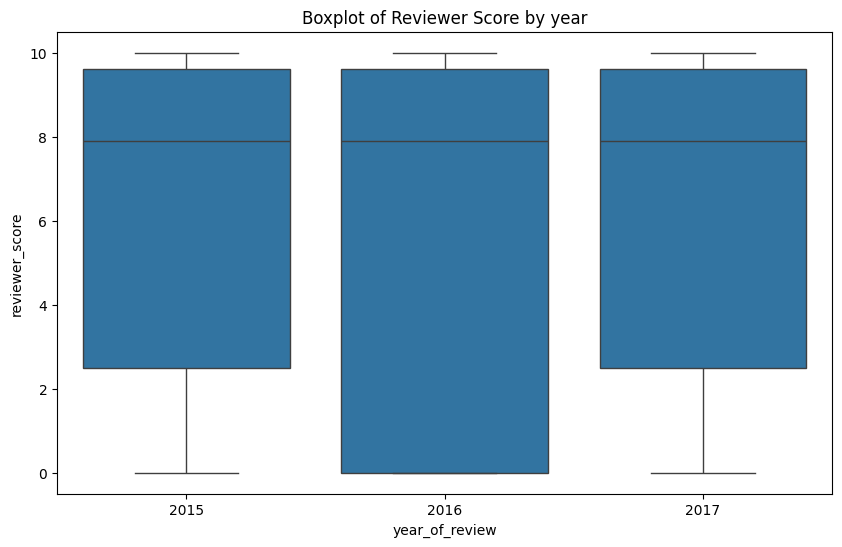

In [227]:
# Построим график boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='year_of_review', y='reviewer_score', data=booking_df)
plt.title('Boxplot of Reviewer Score by year')
plt.show()

Средняя оценка по представленым годам одинаковая. Но в 2016 году оценок больше, чем в других двух.
Посмотрим на оценки по месяцам.

In [228]:
booking_df = pd.get_dummies(booking_df, columns=['year_of_review'])

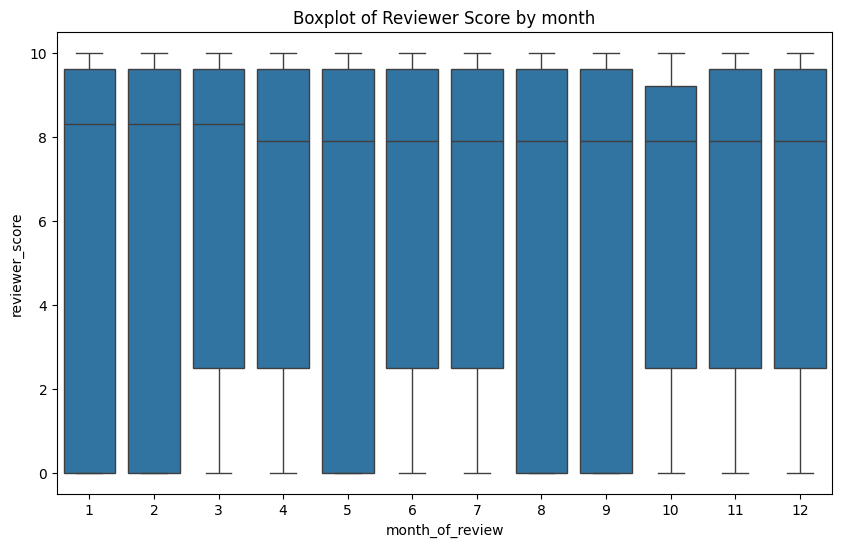

In [229]:
# Построим график boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='month_of_review', y='reviewer_score', data=booking_df)
plt.title('Boxplot of Reviewer Score by month')
plt.show()

Визуально, средняя оценка выше при оценке в первые три месяца года, и не отличается для остальных месяцев, то есть в первый квартал года.
Посмотрим на оценки по кварталам.

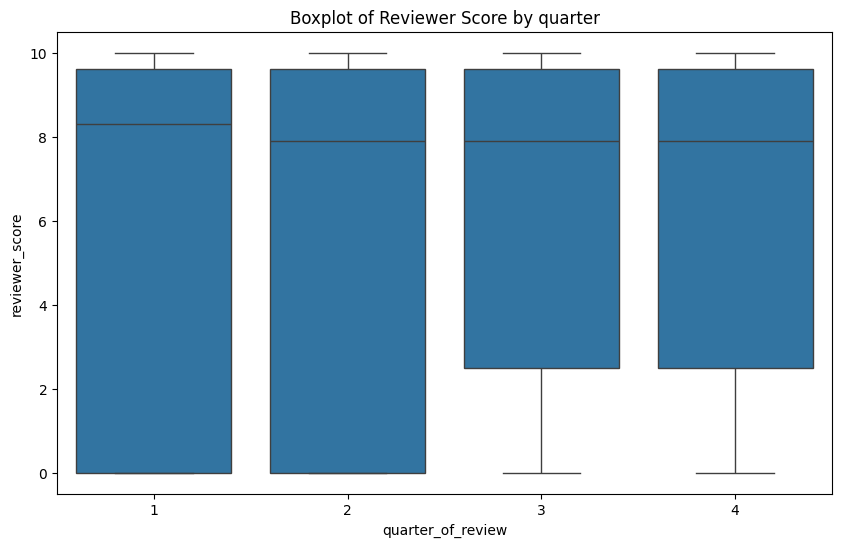

In [230]:
# Построим график boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='quarter_of_review', y='reviewer_score', data=booking_df)
plt.title('Boxplot of Reviewer Score by quarter')
plt.show()

В первый квартал средняя оценка выше чем в остальные 3 квартала.

In [231]:
booking_df = pd.get_dummies(booking_df, columns=['quarter_of_review'])

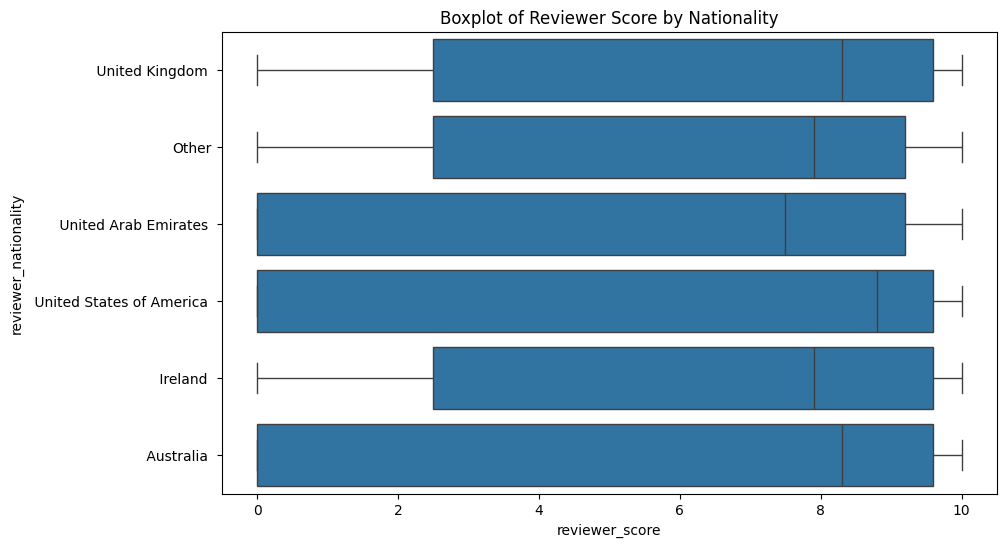

In [232]:
# Построим график boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='reviewer_score', y='reviewer_nationality', data=booking_df)
plt.title('Boxplot of Reviewer Score by Nationality')
plt.show()

In [233]:
booking_df.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tag_Business trip,tag_Group,tag_Family with young children,year_of_review_2015,year_of_review_2016,year_of_review_2017,quarter_of_review_1,quarter_of_review_2,quarter_of_review_3,quarter_of_review_4
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,False,True,False,True,False,False,False
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,1,0,0,False,False,True,True,False,False,False
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,Other,No kettle in room,6,406,No Positive,...,0,0,0,False,True,False,False,False,False,True
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,True,False,False,False,False,True,False
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Other,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,1,0,0,False,True,False,True,False,False,False
5,Via Mecenate 121 20138 Milan Italy,105,2015-12-30,8.0,Novotel Milano Linate Aeroporto,Other,Nothing,2,1607,Very nice hotel Price is excellent when compa...,...,1,0,0,True,False,False,False,False,False,True
6,97 Cromwell Road Kensington and Chelsea London...,854,2017-05-18,7.8,Holiday Inn London Kensington Forum,United Kingdom,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,...,0,0,0,False,False,True,False,True,False,False
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,2017-01-23,8.3,Mercure Josefshof Wien,United Kingdom,The communal areas are a bit soul less and th...,40,2526,The location is good for transport links espe...,...,0,0,0,False,False,True,True,False,False,False
8,190 Queen s Gate Kensington and Chelsea London...,227,2015-11-24,8.6,The Gore Hotel Starhotels Collezione,United Kingdom,undergoing refurbishment no tea coffer in roo...,30,968,staff very good location wonderful,...,0,0,0,True,False,False,False,False,False,True
9,Holland Park Avenue Kensington and Chelsea Lon...,843,2016-02-02,7.8,Hilton London Kensington Hotel,United Kingdom,I advised it was for my husbands birthday and...,47,3801,No Positive,...,0,0,0,False,True,False,True,False,False,False


In [234]:
# Здесь заполняются пропуски значений на 0
booking_df = booking_df.fillna(0)

In [235]:
nan_counts = booking_df.isna().sum()
print(nan_counts)

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
hotel_town                                    0
hotel_country                                 0
month_of_review                         

In [236]:
booking_df

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tag_Business trip,tag_Group,tag_Family with young children,year_of_review_2015,year_of_review_2016,year_of_review_2017,quarter_of_review_1,quarter_of_review_2,quarter_of_review_3,quarter_of_review_4
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,False,True,False,True,False,False,False
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,1,0,0,False,False,True,True,False,False,False
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,Other,No kettle in room,6,406,No Positive,...,0,0,0,False,True,False,False,False,False,True
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,True,False,False,False,False,True,False
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Other,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,1,0,0,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2016-02-03,8.1,Best Western Antares Hotel Concorde,Other,No Negative,0,984,nice breakfast,...,1,0,0,False,True,False,True,False,False,False
515734,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,2016-06-18,7.8,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,...,0,0,0,False,True,False,False,True,False,False
515735,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,2017-07-06,8.0,Suite Hotel 900 m zur Oper,Other,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,...,1,0,0,False,False,True,False,False,True,False
515736,Corso Concordia 1 Milan City Center 20129 Mila...,159,2015-12-26,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,...,0,0,0,True,False,False,False,False,False,True


## Нормализация признаков

In [270]:
num_cols = [
    'additional_number_of_scoring', 'average_score',
    'review_total_negative_word_counts', 'total_number_of_reviews', 
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
    'lat','lng','days_since_review',
    ]

In [271]:
# Задаю уровень значимости
alpha = 0.05 

# Функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

In [272]:
# Проверяю распределение числовых признаков на нормальность с помощью теста Шапиро — Уилка

for col in num_cols:
    print('Признак ' + col)
    result = stats.shapiro(booking_df[col])
    decision_normality(result[1])

Признак additional_number_of_scoring
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак average_score
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_negative_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_positive_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews_reviewer_has_given
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак lat
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от норм

c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 515738.
  res = hypotest_fun_out(*samples, **kwds)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак days_since_review
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Так как все признаки распределены не нормально, используем нормализацию для преобразования. <br> Будем использовать нормализатор RobustScaler, так как мы не выполняли очистку данных.

In [273]:
r_scaler = preprocessing.RobustScaler()
# Кодирую исходный датасет
booking_df[num_cols] = r_scaler.fit_transform(booking_df[num_cols])

In [274]:
booking_df[num_cols].head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,days_since_review
0,0.488798,0.000000,-0.285714,-0.057096,-0.411765,0.571429,0.002395,-0.028778,0.505682
1,-0.085540,-0.142857,-0.285714,-0.315253,-0.529412,1.571429,0.006365,-0.033162,-0.426136
2,-0.629328,0.714286,-0.142857,-0.704731,-0.647059,1.571429,-0.803590,0.436167,-0.181818
3,-0.625255,-1.285714,-0.428571,-0.622757,0.000000,0.714286,-0.790476,0.450848,0.931818
4,1.167006,0.142857,-0.238095,2.223491,0.529412,1.000000,0.268091,0.973443,0.463068


In [275]:
nan_counts = booking_df.isna().sum()
print(nan_counts)

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
hotel_town                                    0
hotel_country                                 0
month_of_review                         

In [276]:
df = booking_df.copy()

In [277]:
# Модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)
df.drop('review_date', axis = 1, inplace=True)

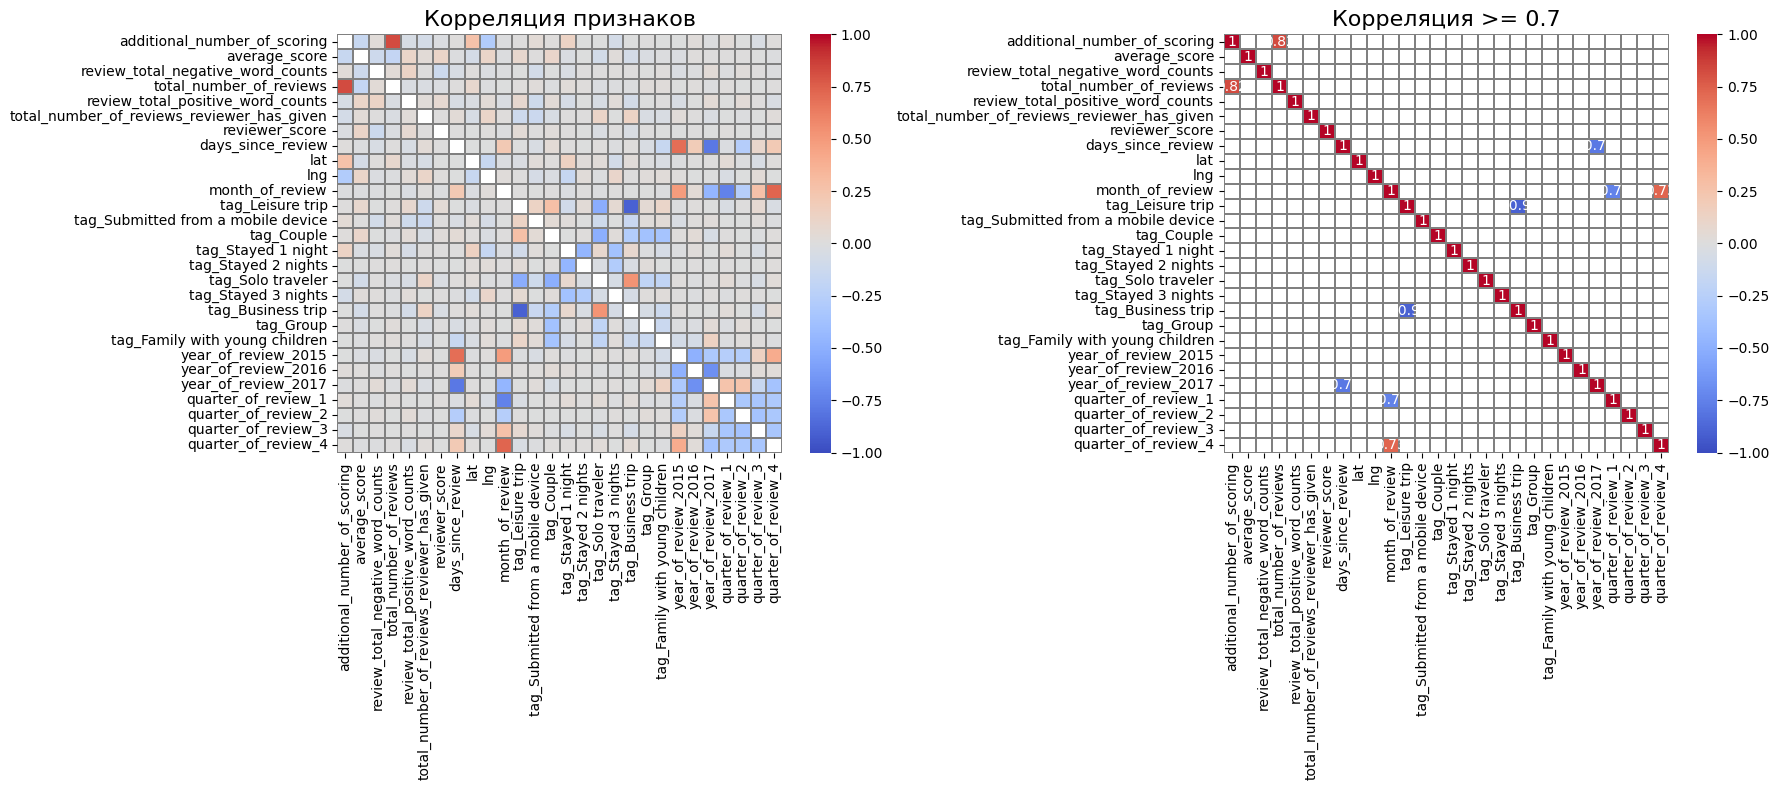

In [278]:
# Посмотрю мультиколлинеарность

# Рассчитываем корреляцию
corr_matrix = df.corr()

# Создаем маску для корреляции >= 0.7
mask = abs(corr_matrix) >= 0.7

# Создаем подграфики
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Строим тепловую карту для всей матрицы корреляции
sns.heatmap(
    corr_matrix, 
    annot=False, 
    cmap='coolwarm', 
    linewidths=0.1, 
    linecolor='gray',
    vmin=-1, vmax=1,
    ax=axes[0],
    annot_kws={'size': 8},  # Уменьшаем размер шрифта аннотаций
    mask=np.eye(len(corr_matrix), dtype=bool)  # Убираем аннотации на диагонали
)
axes[0].set_title('Корреляция признаков', fontsize=16)

# Строим тепловую карту для корреляций >= 0.7
sns.heatmap(
    corr_matrix[mask], 
    annot=True, 
    cmap='coolwarm', 
    linewidths=0.1, 
    linecolor='gray',
    vmin=-1, vmax=1,
    ax=axes[1]
)
axes[1].set_title('Корреляция >= 0.7', fontsize=16)

# Показать графики
plt.tight_layout()
plt.show()

Список признаков для удаления на основании анализа мультиколлинеарности:

* __total_number_of_reviews__ коррелирует с признаком __additional_number_of_scoring__
* __tag_Business_trip__ коррелирует с признаком __tag_Leisure trip__
* __year_of_review_2017__ коррелирует с признаком __days_since_review__
* __month__ коррелирует с группой признаков __quarter_of_review__

In [279]:
lisf_of_delet = [
    'additional_number_of_scoring', 'tag_Business trip', 'days_since_review', 'month_of_review'
]


In [280]:
# Удаляю выбранные признаки
df_final = booking_df.drop(lisf_of_delet, axis=1)

In [281]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df_final.columns if df_final[s].dtypes == 'object' and s != 'sample']
df_final.drop(object_columns, axis = 1, inplace=True)
df_final.drop('review_date', axis = 1, inplace=True)

In [282]:
# Выделяю тестовую часть
train_data = df_final.query('sample == "train"').drop(['sample'], axis=1)
test_data = df_final.query('sample == "test"').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [283]:
# непрерывные признаки
num_cols = ['average_score', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given',
       'lat', 'lng']

# категориальные признаки
cat_cols = ['tag_Leisure trip',
       'tag_Submitted from a mobile device', 'tag_Couple',
       'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Solo traveler',
       'tag_Stayed 3 nights', 'tag_Group', 'tag_Family with young children',
       'quarter_of_review_1','quarter_of_review_2', 'quarter_of_review_3', 'quarter_of_review_4']

<Axes: >

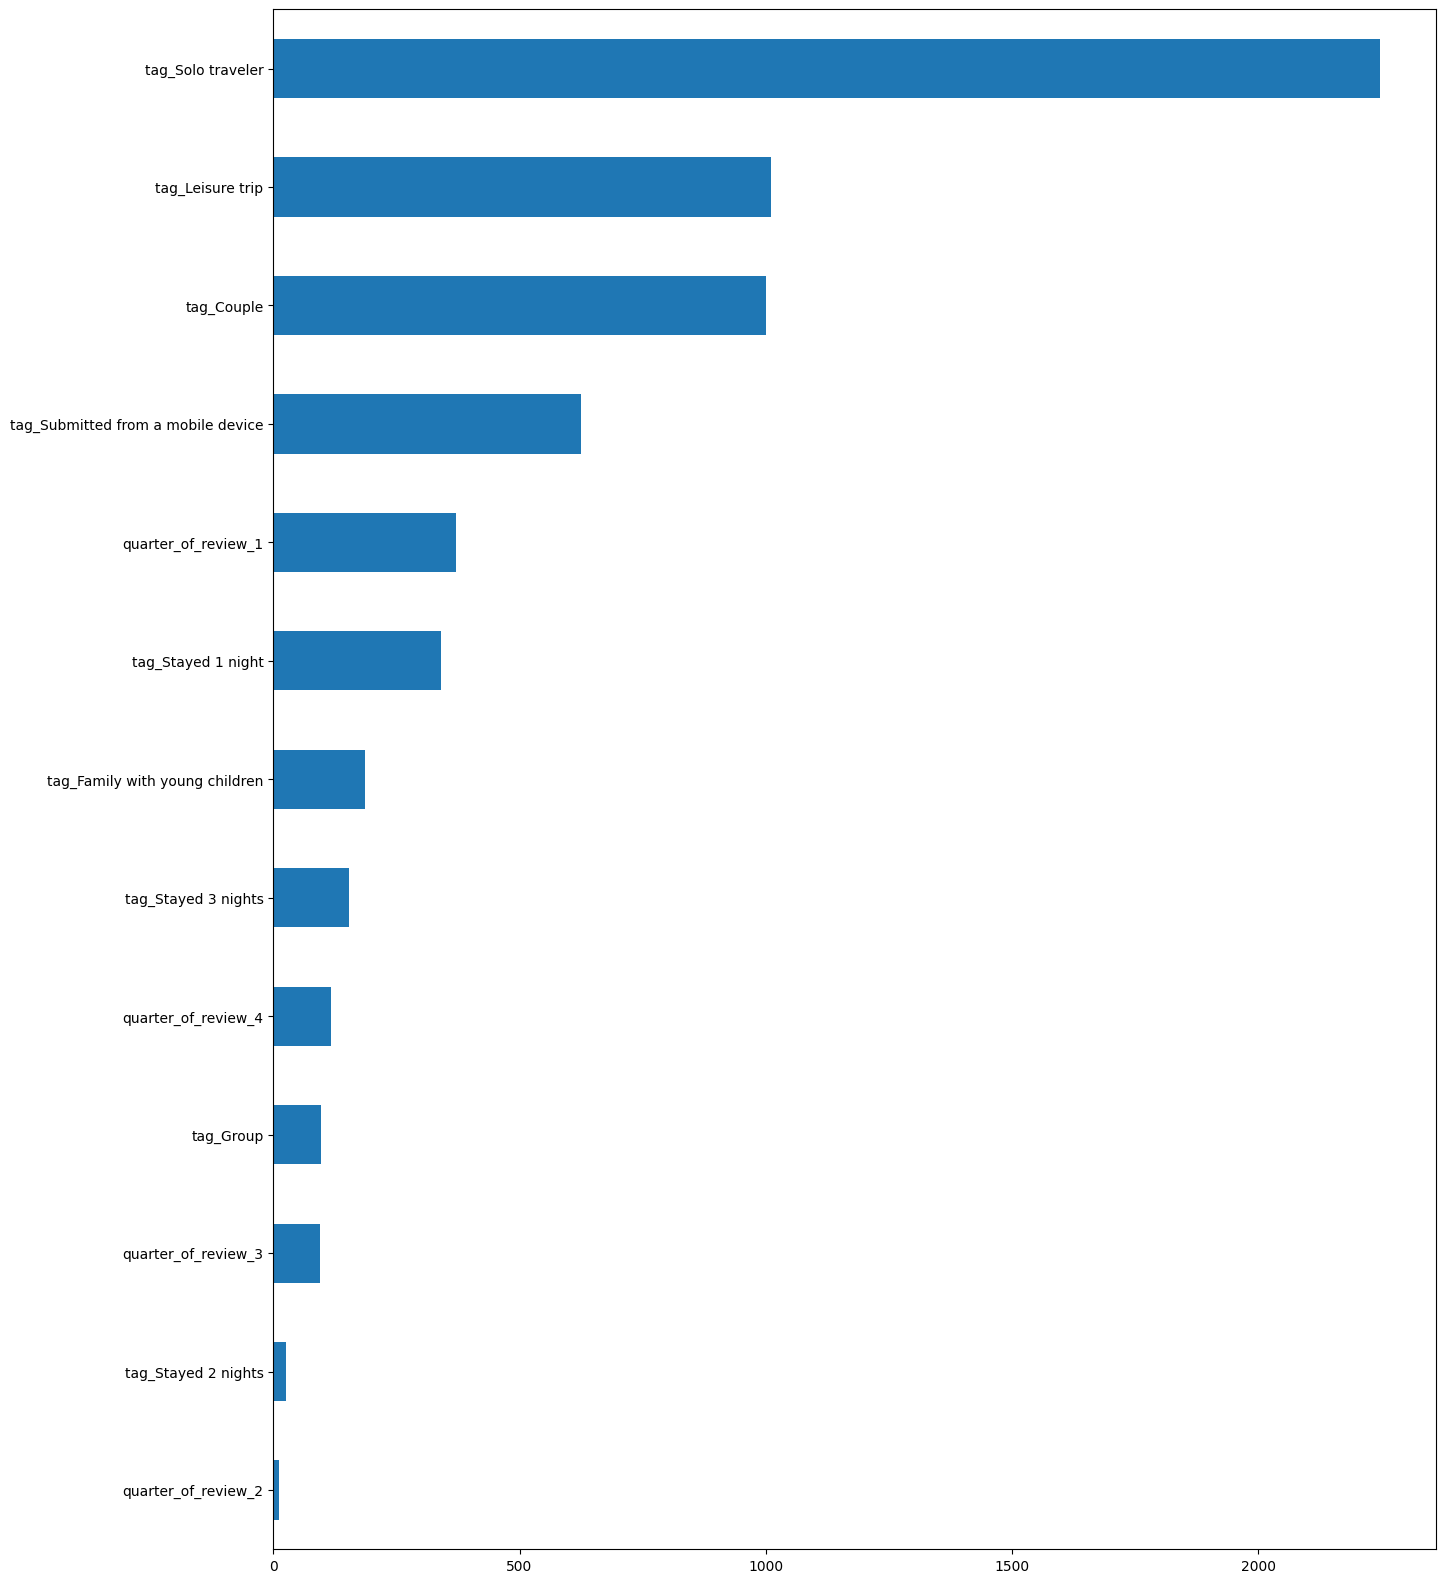

In [284]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(15, 20))
imp_cat.plot(kind = 'barh')

На основе анализа важности признаков удалим признаки кварталов. <br> Оставив только признак первого квартала. <br> так как именно для него отличалось среднее значение оценки в визуальном анализе выше.

In [286]:
columns_drop = ['quarter_of_review_2', 'quarter_of_review_3', 'quarter_of_review_4']

In [287]:
df_final = df_final.drop(columns_drop, axis = 1) 

<Axes: >

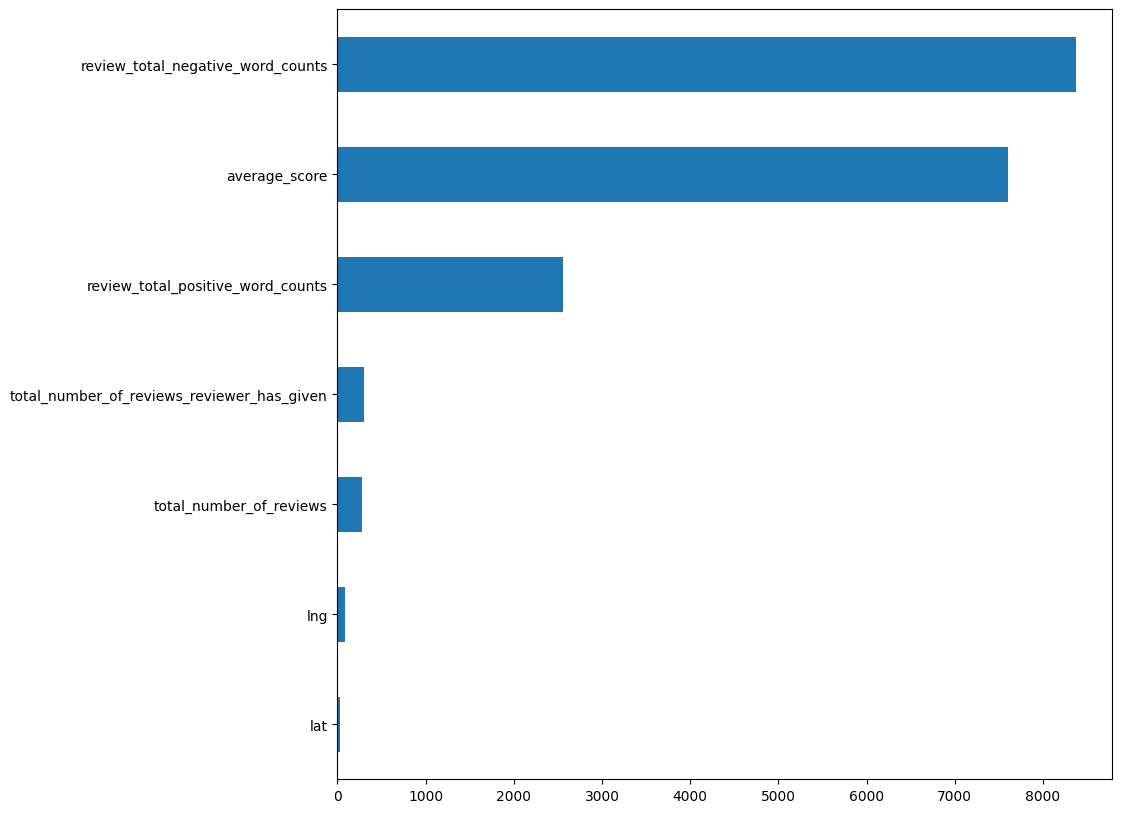

In [285]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
RANDOM_SEED = 10 # Задаю число для воспроизведения случайной генерации

In [289]:
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)
      
# Воспользуюсь специальной функцие train_test_split для разбивки тестовых данных
# Выделяю 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [290]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 24), (386803, 24), (386803, 23), (309442, 23), (77361, 23))

In [291]:
model = CatBoostRegressor()

In [292]:
# Обучаю модель на тестовом наборе данных
model.fit(X_train, y_train)

# Использую обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

Learning rate set to 0.101319
0:	learn: 1.5801332	total: 26.2ms	remaining: 26.1s
1:	learn: 1.5307999	total: 49.8ms	remaining: 24.9s
2:	learn: 1.4880485	total: 76.6ms	remaining: 25.4s
3:	learn: 1.4519311	total: 105ms	remaining: 26s
4:	learn: 1.4218102	total: 134ms	remaining: 26.7s
5:	learn: 1.3955457	total: 162ms	remaining: 26.9s
6:	learn: 1.3728402	total: 191ms	remaining: 27s
7:	learn: 1.3524292	total: 244ms	remaining: 30.3s
8:	learn: 1.3359796	total: 283ms	remaining: 31.1s
9:	learn: 1.3214974	total: 318ms	remaining: 31.4s
10:	learn: 1.3101330	total: 346ms	remaining: 31.2s
11:	learn: 1.3003445	total: 372ms	remaining: 30.6s
12:	learn: 1.2915744	total: 399ms	remaining: 30.3s
13:	learn: 1.2839410	total: 428ms	remaining: 30.1s
14:	learn: 1.2772262	total: 453ms	remaining: 29.8s
15:	learn: 1.2716927	total: 477ms	remaining: 29.3s
16:	learn: 1.2669033	total: 502ms	remaining: 29s
17:	learn: 1.2626646	total: 526ms	remaining: 28.7s
18:	learn: 1.2590845	total: 549ms	remaining: 28.4s
19:	learn: 1.2

In [ ]:
# Сравниваю предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются

# Метрика называется Mean Absolute Percentage Error (MAPE)

# Показывает среднюю абсолютную процентную ошибку 
# предсказанных значений в отношении фактических.  

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13207988745177854


<Axes: >

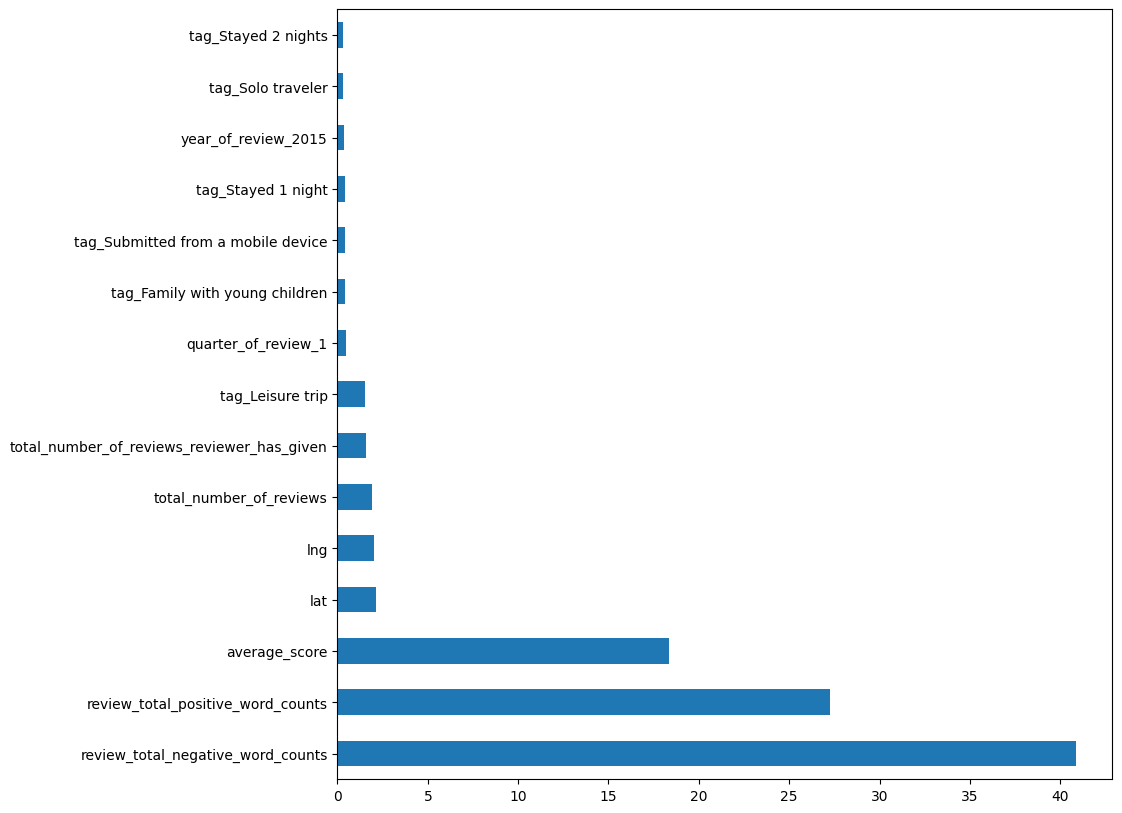

In [294]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Наиболее значимыми признаками являются:

* review_total_negative_word_counts 
* review_total_positive_word_counts 
* average_score

Наименее значимыми признаками являются:

* tag_Stayed 2 nights
* tag_Solo traveler
* year_of_review_2015


In [295]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,tag_Leisure trip,tag_Submitted from a mobile device,...,tag_Stayed 3 nights,tag_Group,tag_Family with young children,year_of_review_2015,year_of_review_2016,year_of_review_2017,quarter_of_review_1,quarter_of_review_2,quarter_of_review_3,quarter_of_review_4
400080,-0.285714,-0.190476,-0.260196,-0.352941,-0.285714,0.0,0.006338,-0.026011,1,1,...,0,0,1,False,False,True,True,False,False,False
416047,0.285714,0.095238,-0.389478,-0.647059,0.142857,0.0,-0.002345,-0.018603,1,0,...,0,0,0,False,True,False,False,False,True,False
388637,0.285714,0.714286,-0.387439,1.647059,0.428571,0.0,-0.795165,0.435796,1,1,...,0,0,1,False,True,False,False,False,True,False
471446,-1.142857,-0.428571,0.174551,0.352941,0.714286,0.0,0.003622,-0.021050,0,1,...,0,0,0,False,True,False,False,False,False,True
486626,0.285714,0.238095,0.580343,-0.176471,-0.285714,0.0,-0.989296,3.437961,0,1,...,0,0,0,False,True,False,True,False,False,False
431085,0.571429,0.809524,0.032219,1.588235,3.000000,0.0,0.000824,-0.019286,1,1,...,1,0,0,False,True,False,False,False,True,False
477049,-0.285714,2.190476,-0.461256,4.000000,0.142857,0.0,-0.002444,-0.023500,1,1,...,0,0,0,False,False,True,False,True,False,False
507017,-0.428571,0.809524,-0.211664,0.764706,4.857143,0.0,0.261843,0.979076,1,0,...,0,0,0,False,False,True,False,True,False,False
428908,0.285714,-0.095238,0.298124,-0.352941,-0.285714,0.0,0.265311,0.984771,1,1,...,0,1,0,False,True,False,False,False,True,False
496225,0.428571,-0.047619,-0.092170,0.058824,-0.285714,0.0,-3.063499,0.403603,1,1,...,1,1,0,False,False,True,True,False,False,False


In [296]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [297]:
sample_submission = pd.read_csv('./data/submission.csv') # самбмишн

In [298]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [299]:
predict_submission = model.predict(test_data)
predict_submission

array([8.48646573, 7.66159542, 8.44322195, ..., 7.89771828, 9.42421889,
       7.0923432 ])

In [300]:
list(sample_submission)

['reviewer_score', 'id']

In [301]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.486466,488440
1,7.661595,274649
2,8.443222,374688
3,9.595469,404352
4,9.505086,451596
5,8.751672,302161
6,8.144068,317079
7,7.754625,13963
8,8.757918,159785
9,7.717524,195089


__Вывод__
В ходе работы были выполнены следующие этапы:

* Очистка данных от пропусков и неинформативных признаков
* Генерация новых признаков на основе имеющихся данных
* Преобразование данных в формат, удобный для машинного обучения
* Отбор наиболее значимых признаков
* Построение и обучение модели
__Результаты__:

На тестовых данных метрика _MAPE_ составила __0.1321__, что примерно на __1__ процентный пункт выше, чем до этапа разведочного анализа данных (EDA).

Наибольший прирост точности модели был достигнут за счет генерации новых признаков. <br> Вклад отбора признаков на этапе анализа их значимости оказался менее __0.1__ процентного пункта. <br> При этом удаление большего числа признаков приводило к ухудшению качества модели.